# Barış Işık 2018702069 

In [1]:
import pandas as pd
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
Consumption = pd.read_csv("EnergyConsumption.csv",encoding = "ISO-8859-1")

# rename columns
Consumption.columns = ["Date","Hour","Consumption_Mwh"]

- Some adjustments on  columns:

In [3]:
Consumption["Consumption_Mwh"] = Consumption["Consumption_Mwh"].str.replace("\.","").str.replace(",",".").astype(float)
# YMDH is Year month day hour concatenated together as integer, this will be the key of the tableau 
Consumption["YMDH"] = Consumption["Date"].str.slice(start = 6, stop = 10) + Consumption["Date"].str.slice(start = 3, stop = 5) + Consumption["Date"].str.slice(start = 0, stop = 2) + Consumption["Hour"].str.slice(start = 0, stop = 2)
Consumption["YMDH"] = Consumption["YMDH"].astype(int)
Consumption["Year"] = Consumption["Date"].str.slice(start = 6, stop = 10).astype(int)
Consumption["Month"] = Consumption["Date"].str.slice(start = 3, stop = 5).astype(int)
Consumption["Day"] = Consumption["Date"].str.slice(start = 0, stop = 2).astype(int)
Consumption["Hour"] = Consumption["Hour"].str.slice(start = 0, stop = 2).astype(int)

Consumption["Date"] = pd.to_datetime(Consumption["Date"],format='%d.%m.%Y')
Consumption = Consumption.loc[Consumption.YMDH < 2019112400]

In [4]:
Consumption = Consumption.sort_values(by=["YMDH"])

In [5]:
Consumption["Lag48"] = Consumption.Consumption_Mwh.shift(48)
Consumption["Lag168"] = Consumption.Consumption_Mwh.shift(168)

#### Part a-)

In [6]:
Part_a = Consumption.loc[Consumption.YMDH > 2019110000].copy()

In [7]:
Part_a["Part_a_48_MAPE"] = abs(Part_a.Consumption_Mwh - Part_a.Lag48)/Part_a.Consumption_Mwh
Part_a["Part_a_168_MAPE"] = abs(Part_a.Consumption_Mwh - Part_a.Lag168)/Part_a.Consumption_Mwh

In [8]:
ErrorSummary = Part_a.iloc[:,(Part_a.shape[1]-2):Part_a.shape[1]].describe()

In [9]:
ErrorSummary

,Part_a_48_MAPE,Part_a_168_MAPE
count,552.000000,552.000000
mean,0.073793,0.028484
std,0.083057,0.034391
min,0.000016,0.000053
25%,0.009978,0.008477
50%,0.053919,0.017238
75%,0.093370,0.030742
max,0.418299,0.211999


- Looking at the sumamry table abova, naive forecast using a week ago's consumpiton has better than the other with 2 days ago's consumtion considering their accuracy comparing its mean, median and max MAPEs. It is something we would expect because of the weekly seasonality of the days. Both weekends and weekdays have their own patterns.

#### Part b-)

In [10]:
from sklearn import linear_model
import random

In [11]:
Part_b_Train = Consumption.loc[(np.isnan(Consumption.Lag168) == False) & (Consumption.YMDH < 2019110000)].copy()
Part_b_Test = Consumption.loc[Consumption.YMDH > 2019110000].copy()

In [12]:
random.seed(15)
Reg_b = linear_model.LinearRegression(n_jobs = -1)
Reg_b.fit(X = Part_b_Train.loc[:,["Lag48","Lag168"]],y = Part_b_Train["Consumption_Mwh"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [13]:
Part_b_Test["Predict"] = Reg_b.predict(Part_b_Test.loc[:,["Lag48","Lag168"]])
Part_b_Test["Part_b_MAPE"] = abs(Part_b_Test.Consumption_Mwh - Part_b_Test.Predict)/Part_b_Test.Consumption_Mwh

In [14]:
ErrorSummary["Part_b_MAPE"] = Part_b_Test.iloc[:,Part_b_Test.shape[1]-1].describe()

In [15]:
ErrorSummary

,Part_a_48_MAPE,Part_a_168_MAPE,Part_b_MAPE
count,552.000000,552.000000,552.000000
mean,0.073793,0.028484,0.037992
std,0.083057,0.034391,0.038707
min,0.000016,0.000053,0.000042
25%,0.009978,0.008477,0.011008
50%,0.053919,0.017238,0.025363
75%,0.093370,0.030742,0.050647
max,0.418299,0.211999,0.225920


- Linear regression with input of lag 48 and lag 168 has slightly worse results then naive with lag 168. But it still covers the weakly seasonality and beats the naive with lag 48.

#### Part c-)

In [16]:
Part_c_Train = Consumption.loc[(np.isnan(Consumption.Lag168) == False) & (Consumption.YMDH < 2019110000)].copy()
Part_c_Test = Consumption.loc[Consumption.YMDH > 2019110000].copy()

In [17]:
random.seed(15)
for i in np.arange(0,24):
    Reg_c = linear_model.LinearRegression(n_jobs = -1)
    Reg_c.fit(X = Part_c_Train.loc[Part_c_Train.Hour == i,["Lag48","Lag168"]],y = Part_c_Train.loc[Part_c_Train.Hour == i,"Consumption_Mwh"])
    Part_c_Test.loc[Part_c_Test.Hour == i,"Predict"] = Reg_c.predict(Part_c_Test.loc[Part_c_Test.Hour == i,["Lag48","Lag168"]])

In [18]:
Part_c_Test["Part_c_MAPE"] = abs(Part_c_Test.Consumption_Mwh - Part_c_Test.Predict)/Part_c_Test.Consumption_Mwh

In [19]:
ErrorSummary["Part_c_MAPE"] = Part_c_Test.iloc[:,Part_c_Test.shape[1]-1].describe()

In [20]:
ErrorSummary

,Part_a_48_MAPE,Part_a_168_MAPE,Part_b_MAPE,Part_c_MAPE
count,552.000000,552.000000,552.000000,552.000000
mean,0.073793,0.028484,0.037992,0.038907
std,0.083057,0.034391,0.038707,0.035645
min,0.000016,0.000053,0.000042,0.000161
25%,0.009978,0.008477,0.011008,0.012847
50%,0.053919,0.017238,0.025363,0.028093
75%,0.093370,0.030742,0.050647,0.054245
max,0.418299,0.211999,0.225920,0.202304


- Training seperate linear fit to each hour does not make the overall MAPE better. One possible reason might be that individual models have less data so models tend to have more variance.

#### Part d-)

In [21]:
Part_d = Consumption.loc[:,["Date","Hour","Consumption_Mwh"]].copy()

Part_d_pivot = Part_d.pivot(index = "Date",columns = "Hour", values = "Consumption_Mwh").copy()

Part_d_pivot = Part_d_pivot.sort_values(by=["Date"])
Last48 = Part_d_pivot.shift(2)
Last48.columns = ["Hour" + str(i) for i in range(0,24)]

Last168 = Part_d_pivot.shift(7)
Last168.columns = ["Hour" + str(i) for i in range(0,24)]

Part_d_pivot = pd.merge(left = Last48,right = Last168,on = "Date" ,suffixes = ('_2daysAgo','_7daysAgo'))

Part_d_pivot = Part_d_pivot.loc[np.isnan(Part_d_pivot.Hour14_7daysAgo) == False]

FeatureCols = Part_d_pivot.columns.copy()

Part_d = Part_d.merge(Part_d_pivot, on = "Date", how = "inner")

In [22]:
from datetime import date
Part_d_Train = Part_d.loc[Part_d.Date < pd.Timestamp(date(2019,11,1))]
Part_d_Test = Part_d.loc[Part_d.Date >= pd.Timestamp(date(2019,11,1))]

In [23]:
random.seed(15)
from sklearn.linear_model import LassoCV
for i in np.arange(0,24):
    
    Reg_d = LassoCV(cv=10,n_jobs = -1,max_iter=3000)
    Target = Part_d_Train.columns.isin(["Date","Hour","Consumption_Mwh"])
    Reg_d.fit(X = Part_d_Train.loc[Part_d_Train.Hour == i, ~Part_d_Train.columns.isin(["Date","Hour","Consumption_Mwh"])],\
                  y = Part_d_Train.loc[Part_d_Train.Hour == i,"Consumption_Mwh"])
    Temp_hour = Part_d_Test.loc[Part_d_Test.Hour == i].copy()
    if i == 0:
        Temp_test = Temp_hour.copy()
        Temp_test["Predict"] = Reg_d.predict(Temp_hour.loc[:,~Part_d_Test.columns.isin(["Date","Hour","Consumption_Mwh"])])
    else:
        Temp_hour["Predict"] = Reg_d.predict(Temp_hour.loc[:,~Part_d_Test.columns.isin(["Date","Hour","Consumption_Mwh"])])
        Temp_test = Temp_test.append(Temp_hour) 
    
Part_d_Test = Temp_test.copy()

In [24]:
Part_d_Test["Part_d_MAPE"] = abs(Part_d_Test.Consumption_Mwh - Part_d_Test.Predict)/Part_d_Test.Consumption_Mwh

In [25]:
ErrorSummary["Part_d_MAPE"] = Part_d_Test.iloc[:,Part_d_Test.shape[1]-1].describe()

In [26]:
ErrorSummary

,Part_a_48_MAPE,Part_a_168_MAPE,Part_b_MAPE,Part_c_MAPE,Part_d_MAPE
count,552.000000,552.000000,552.000000,552.000000,552.000000
mean,0.073793,0.028484,0.037992,0.038907,0.023927
std,0.083057,0.034391,0.038707,0.035645,0.022223
min,0.000016,0.000053,0.000042,0.000161,0.000076
25%,0.009978,0.008477,0.011008,0.012847,0.008520
50%,0.053919,0.017238,0.025363,0.028093,0.017615
75%,0.093370,0.030742,0.050647,0.054245,0.031157
max,0.418299,0.211999,0.225920,0.202304,0.119143


- Model in part d beats the rest. Wide range format seems to work well. But we should note that both feautre set and the model we use has changed. I wanted to find the main reason behind the improvement in accuracy, so I tried lasso with features set in part c and usual linear regression with feature set in part d. They are not present in the reports but none of these models was successful. Combination of wide feature set and lasso is critical because lasso can handle large number of features where the linear regression cant.

#### Part f-) 

In [27]:
Part_a = Part_a.sort_values(by=["YMDH"]).reset_index(drop = True).loc[:,["Part_a_48_MAPE","Part_a_168_MAPE"]]
Part_b_Test = Part_b_Test.sort_values(by=["YMDH"]).reset_index(drop = True).loc[:,"Part_b_MAPE"]
Part_c_Test = Part_c_Test.sort_values(by=["YMDH"]).reset_index(drop = True).loc[:,"Part_c_MAPE"]
Part_d_Test = Part_d_Test.sort_values(by=["Date","Hour"]).reset_index(drop = True).loc[:,"Part_d_MAPE"]

Plot = pd.concat([Part_a, Part_b_Test,Part_c_Test,Part_d_Test], axis=1)

Plot = pd.melt(Plot, value_vars=Plot.columns)

In [29]:
from plotnine import *

p = ggplot(Plot, aes(x="variable", y="value")) + geom_boxplot()

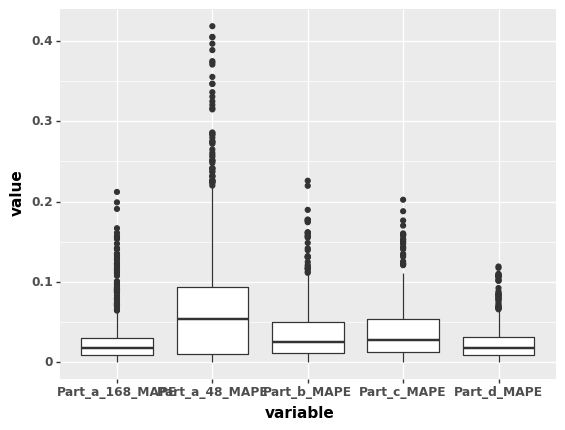

<ggplot: (81714028040)>

In [30]:
p

- Both mean and range(also imlies standard deviation) of the errors in part a with lag 168 and part is is considerably narrower compared to others.